In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import random

In [ ]:
seed=42

# Code

In [ ]:
def create_data(n, noise=False, sigma=0.1):
    # creade set of points at circle with R=1
    phi = 2 * np.pi * np.arange(n) / n    # np.random.rand(n) # np.arange(n) / n
    x, y = np.cos(phi), np.sin(phi)
    if noise:
        x += np.random.normal(0, sigma, n)
        y += np.random.normal(0, sigma, n)
    data = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    return data

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def single_pass(model, dataloader, loss_func, device, optim=None):
    loss_count = 0
    for i, data in enumerate(dataloader):
        data = data.float().to(device)
        pred = model.forward(data)
        loss = loss_func(pred, data)    ####
        loss_count += loss.item()

        if optim is not None:
            loss.backward()
            optim.step()
            optim.zero_grad()
    return loss_count / len(dataloader)

def train_model(model, loss, optim, epochs, device, datas, print_step=10):
    data_train, data_val = datas
    dataloader_train = DataLoader(MyDataset(data_train), batch_size, shuffle=True)
    dataloader_val = DataLoader(MyDataset(data_val), batch_size, shuffle=True)
    train_loss_all, val_loss_all = [], []
    # training loop
    for epoch in range(epochs):
        # train
        train_loss = single_pass(model, dataloader_train, loss, device, optim)
        
        if epoch % print_step == 0:
            # validation
            with torch.no_grad():
                val_loss = single_pass(model, dataloader_val, loss, device)
            print(
                f'epoch {epoch}, train_loss={train_loss}, val_loss={val_loss}')

            train_loss_all.append(train_loss)
            val_loss_all.append(val_loss)

    return train_loss_all, val_loss_all


In [ ]:
def print_examples(model):
    data = create_data(100)
    with torch.no_grad():
        pred = model.forward(torch.tensor(data).float().to(device)).detach().cpu().numpy()
    x, y = data[:, 0], data[:, 1]
    x_pred, y_pred = pred[:, 0], pred[:, 1]

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, label='true')
    plt.scatter(x_pred, y_pred, label='pred')
    plt.show()

# model

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, h=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 2),
            # nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
  
print('number of params:', sum(p.numel() for p in AutoEncoder().parameters()))



number of params: 135


### Example

epoch 0, train_loss=0.44241256994957273, val_loss=0.3105295025385343
epoch 10, train_loss=0.2528762378814546, val_loss=0.24542557849333838
epoch 20, train_loss=0.19349640125239437, val_loss=0.17644628710471666
epoch 30, train_loss=0.08546757192181592, val_loss=0.09392988595824975
epoch 40, train_loss=0.07447124206969007, val_loss=0.061045992403076246
epoch 50, train_loss=0.0629158893134445, val_loss=0.08340941956983162
epoch 60, train_loss=0.05062492993998934, val_loss=0.048229770305065006
epoch 70, train_loss=0.045903917465528306, val_loss=0.04558507911860943
epoch 80, train_loss=0.0356449244692075, val_loss=0.03973182691977574
epoch 90, train_loss=0.027418190317059107, val_loss=0.029342731460928917
epoch 100, train_loss=0.03650248337494717, val_loss=0.04069007488970573
epoch 110, train_loss=0.03283389321189712, val_loss=0.021806016206168212
epoch 120, train_loss=0.043528519083999774, val_loss=0.024319983051659968
epoch 130, train_loss=0.032561841918240214, val_loss=0.0207474867168527

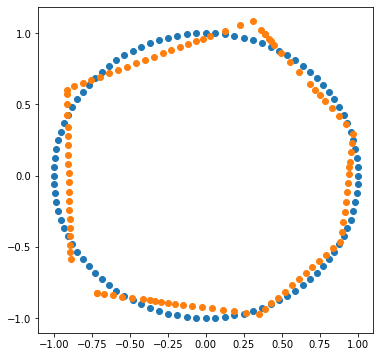

In [ ]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 600
lr = 5*1e-3
optim = Adam(model.parameters(), lr=lr)
loss = F.mse_loss

# generate data and create data
data_train = create_data(700)
data_val = create_data(100)
datas = [data_train, data_val]

# train model
train_loss, val_loss = train_model(model, loss, optim, epochs, device, datas)

# look at examples
print_examples(model)